In [ ]:
# Install required packages
! pip install opencv-python
! pip install numpy
! pip install tensorflow
! pip install torch
! pip install PyQt5
! pip install PyQt5-tools
! pip install matplotlib
! pip install pandas
! pip install scikit-learn
! pip install albumentations
! pip install ultralytics
! pip install jupyter

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
def setup_yolo_dataset():
    """Setup YOLO dataset with proper class mappings"""
    base_dir = 'yolo_dataset'
    
    # Create YAML configuration
    yaml_content = """
path: ../yolo_dataset  # dataset root dir
train: train/images  # train images
val: val/images      # val images
test: test/images    # test images

names:
  0: person
  1: weapon
  2: person_with_weapon
"""
    
    with open('data.yaml', 'w') as f:
        f.write(yaml_content.strip())
    
    # Print dataset statistics
    for split in ['train', 'val', 'test']:
        img_dir = os.path.join(base_dir, split, 'images')
        if os.path.exists(img_dir):
            print(f"{split}: {len(os.listdir(img_dir))} images")

In [3]:
class WeaponDetectionSystem:
    def __init__(self, model_size='m'):
        self.model = None
        self.model_size = model_size
    
    def load_model(self, weights_path=None):
        if weights_path:
            self.model = YOLO(weights_path)
        else:
            self.model = YOLO(f'yolov8{self.model_size}.pt')
        self.model.conf = 0.25
        self.model.iou = 0.45
    
    def detect(self, image_path):
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not read image: {image_path}")
            
            results = self.model(image, augment=True)
            annotated_image = image.copy()
            detections = []
            
            for r in results[0].boxes.data:
                x1, y1, x2, y2, conf, cls = r.cpu().numpy()
                
                if conf < self.model.conf:
                    continue
                    
                classes = {0: 'Person', 1: 'Weapon', 2: 'Armed Person'}
                colors = {0: (0,255,0), 1: (0,0,255), 2: (255,0,0)}
                
                cls_idx = int(cls)
                label = classes[cls_idx]
                color = colors[cls_idx]
                
                cv2.rectangle(annotated_image, 
                            (int(x1), int(y1)), 
                            (int(x2), int(y2)), 
                            color, 3)
                
                label_text = f'{label}: {conf:.2f}'
                cv2.putText(annotated_image, 
                          label_text,
                          (int(x1), int(y1) - 5),
                          cv2.FONT_HERSHEY_SIMPLEX,
                          0.6, color, 2)
                
                detections.append({
                    'class': label,
                    'confidence': float(conf),
                    'bbox': [int(x1), int(y1), int(x2), int(y2)]
                })
                
            return annotated_image, detections
                
        except Exception as e:
            print(f"Error processing image: {str(e)}")
            return None, None

In [4]:
def train_model(detector, epochs=50):
    """Train the weapon detection model"""
    print("Training model...")
    
    # Load base model if not loaded
    if detector.model is None:
        detector.load_model()
    
    results = detector.model.train(
        data='data.yaml',
        epochs=epochs,
        imgsz=640,
        batch=16,
        name=f'weapon_detector_{detector.model_size}',
        device='0' if torch.cuda.is_available() else 'cpu',
        patience=20,
        save=True,
        pretrained=True,
        optimizer='AdamW',
        lr0=0.001,
        lrf=0.0001
    )
    
    return results

In [18]:
def evaluate_model(detector):
    """Evaluate model performance on test set with detailed metrics"""
    
    print("Evaluating on test set...")
    metrics = detector.model.val(
        data='data.yaml',
        split='test',
        conf=0.25,
        iou=0.45,
        verbose=True
    )
    
    test_dir = 'yolo_dataset/test/images'
    class_counts = {
        'Person': {'correct': 0, 'total': 0},
        'Weapon': {'correct': 0, 'total': 0},
        'Armed Person': {'correct': 0, 'total': 0}
    }
    
    print("\nDetailed per-class evaluation:")
    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        _, detections = detector.detect(img_path)
        
        if detections:
            for det in detections:
                class_name = det['class']
                confidence = det['confidence']
                
                class_counts[class_name]['total'] += 1
                if confidence > 0.5:
                    class_counts[class_name]['correct'] += 1
    
    print("\nPer-class Accuracy:")
    for class_name, counts in class_counts.items():
        accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else 0
        print(f"{class_name}: {accuracy:.2%} ({counts['correct']}/{counts['total']})")
    
    return metrics

In [19]:
def plot_confusion_matrix(detector):
    """Plot confusion matrix for test set"""
    y_true = []
    y_pred = []
    
    test_dir = 'yolo_dataset/test/images'
    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)
        _, detections = detector.detect(img_path)
        
        if detections:
            for det in detections:
                class_name = det['class']
                y_pred.append(class_name)
                # Note: You need to add ground truth labels
                # y_true.append(true_label)
    
    classes = ['Person', 'Weapon', 'Armed Person']
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [20]:
# Setup dataset
setup_yolo_dataset()

# Initialize detector
detector = WeaponDetectionSystem(model_size='m')

# Train model
train_results = train_model(detector)

# Load best weights after training
detector.load_model('runs/detect/weapon_detector_m/weights/best.pt')

# Evaluate model
metrics = evaluate_model(detector)
plot_confusion_matrix(detector)

train: 571 images
val: 20 images
test: 23 images
Training model...
Ultralytics 8.3.49  Python-3.11.3 torch-2.5.1+cpu CPU (Intel Core(TM) i5-8265U 1.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=50, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=weapon_detector_m4, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=

train: Scanning C:\Users\Idris\Desktop\AI-WDS\yolo_dataset\train\labels.cache... 571 images, 0 backgrounds, 0 corrupt: 100%|██████████| 571/571 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning C:\Users\Idris\Desktop\AI-WDS\yolo_dataset\val\labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs\detect\weapon_detector_m4\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\weapon_detector_m4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/36 [00:00<?, ?it/s]


0: 384x640 1 weapon, 256.6ms
Speed: 5.0ms preprocess, 256.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


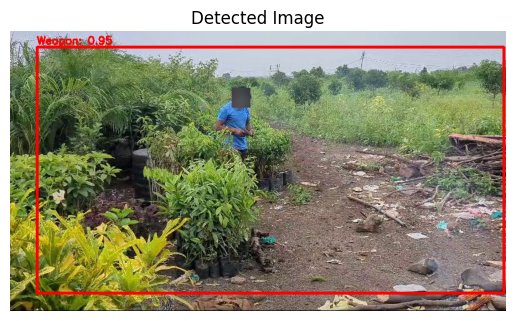

Detections: [{'class': 'Weapon', 'confidence': 0.9539364576339722, 'bbox': [46, 27, 844, 447]}]


In [11]:
# Initialize the detector
detector = WeaponDetectionSystem(model_size='m')

# Load the trained model weights
detector.load_model('runs/detect/weapon_detector13/weights/best.pt')

# Test the detector with an example image
test_image_path = 'yolo_dataset/val/images/dc_gun_2k24_000039_ba8a2ea9.jpg'
annotated_image, detections = detector.detect(test_image_path)

# Display the annotated image using matplotlib
if annotated_image is not None:
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Image')
    plt.axis('off')
    plt.show()

# Print the detections
print("Detections:", detections)